In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image, ImageChops
import gc
import os, sys, time
import math
import random
import cv2
from skimage.data import camera
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
import yolov2

mobilenetv2 = yolov2.load_mobilenetv2_224_075_detector("E:\ML\Deepfake Challenge Kaggle\\facedetection-mobilenetv2-size224-alpha0.75.h5")
yolo_model = yolov2.FaceDetector(model=mobilenetv2)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [7]:
def getFrames(path):
    capture = cv2.VideoCapture(path)
    frame_count = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
    frames = []
    i = 0
    while(capture.isOpened()):            
        #all frames
        ret, frame = capture.read()
        if ret == False:
            break
            
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        # plt.imshow(frame)
        # plt.show()
        frames.append(frame)
        i += 1
    
    capture.release()
    #return frames
    print("Extracted: " + str(len(frames)) + " frames!")
    print(frames[0].shape)
    return frames

In [14]:
input_size = 224
def isotropically_resize_image(img, size, resample=cv2.INTER_AREA):
    h, w = img.shape[:2]
    if w > h:
        h = h * size // w
        w = size
    else:
        w = w * size // h
        h = size

    resized = cv2.resize(img, (w, h), interpolation=resample)
    return resized


def make_square_image(img):
    h, w = img.shape[:2]
    size = max(h, w)
    t = 0
    b = size - h
    l = 0
    r = size - w
    return cv2.copyMakeBorder(img, t, b, l, r, cv2.BORDER_CONSTANT, value=0)

In [58]:
def get_faces(real_fs, fake_fs):
    faces = []
    for idx in range(len(real_fs)):
        yolo_boxes = yolo_model.detect(real_fs[idx], 0.8)
        yb = yolov2.get_boxes_points(yolo_boxes, real_fs[idx].shape)
        
        for b in yb:
            lx, ly, rx, ry = b
            # x, y, w, h here
            # ax.add_patch(Rectangle((lx,ly),rx - lx,ry - ly,linewidth=2,edgecolor='red',facecolor='none'))
            real_crop = real_fs[idx][ly+5:ry-5, lx+5:rx-5]
            real_resized_face = isotropically_resize_image(real_crop, input_size)
            real_resized_face = make_square_image(real_resized_face)

            fake_crop = fake_fs[idx][ly+5:ry-5, lx+5:rx-5]
            fake_resized_face = isotropically_resize_image(fake_crop, input_size)
            fake_resized_face = make_square_image(fake_resized_face)
            faces.append((real_resized_face,fake_resized_face))
    return faces

In [8]:
fake_frames = getFrames("aalqaiyuxt.mp4")

Extracted: 300 frames!
(1080, 1920, 3)


In [9]:
real_frames = getFrames("tassoafzsu.mp4")

Extracted: 300 frames!
(1080, 1920, 3)


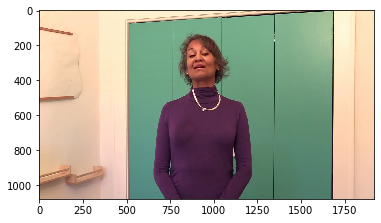

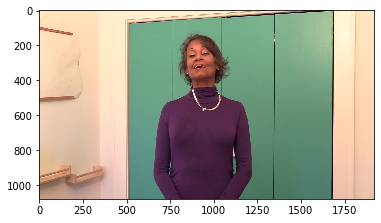

In [102]:
plt.figure()
plt.imshow(fake_frames[10])
plt.show()
plt.figure()
plt.imshow(real_frames[10])
plt.show()

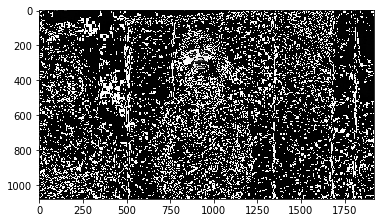

In [101]:
real_full = cv2.cvtColor(real_frames[10], cv2.COLOR_RGB2GRAY)
fake_full = cv2.cvtColor(fake_frames[10], cv2.COLOR_RGB2GRAY)
diff_full = real_full-fake_full
plt.figure()
plt.imshow(diff_full, cmap='gray')
plt.show()

In [59]:
rf0, ff0 = get_faces([real_frames[10]], [fake_frames[10]])[0]

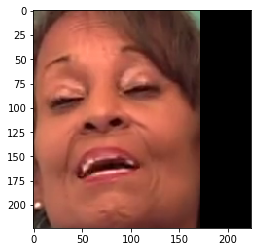

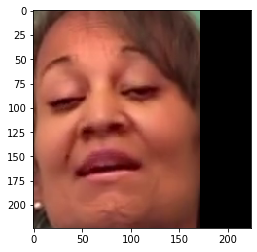

In [60]:
plt.figure()
plt.imshow(rf0)
plt.show()
plt.figure()
plt.imshow(ff0)
plt.show()

In [67]:
rf0_denoised = cv2.fastNlMeansDenoisingColored(rf0,None,3,10,7,21)
ff0_denoised = cv2.fastNlMeansDenoisingColored(ff0,None,3,10,7,21)

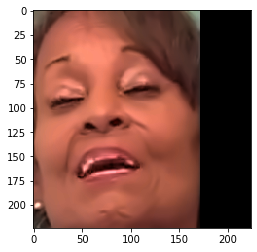

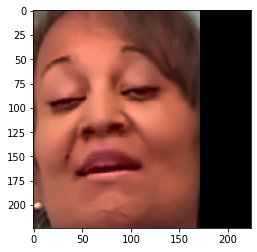

In [68]:
plt.figure()
plt.imshow(rf0_denoised)
plt.show()
plt.figure()
plt.imshow(ff0_denoised)
plt.show()

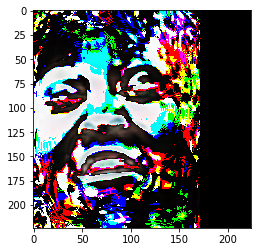

In [70]:
rf_denoised = rf0_denoised - ff0_denoised
plt.figure()
plt.imshow(rf_denoised)
plt.show()

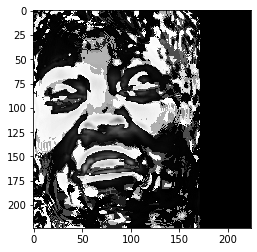

In [82]:
rfg_denoised = cv2.cvtColor(rf_denoised, cv2.COLOR_RGB2GRAY)
plt.figure()
plt.imshow(rfg_denoised, cmap='gray')
plt.show()

In [61]:
rf = rf0 - ff0 #Do this
fr = ff0 - rf0 #Not this

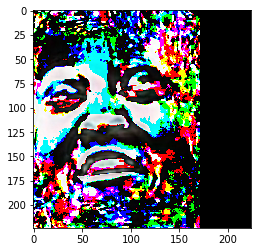

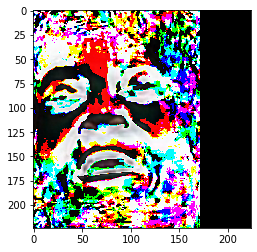

In [62]:
plt.figure()
plt.imshow(rf)
plt.show()
plt.figure()
plt.imshow(fr)
plt.show()

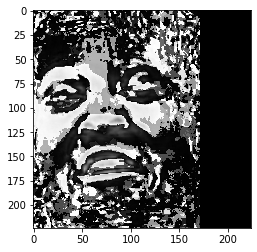

In [79]:
rfg = cv2.cvtColor(rf, cv2.COLOR_RGB2GRAY)
plt.figure()
plt.imshow(rfg, cmap='gray')
plt.show()

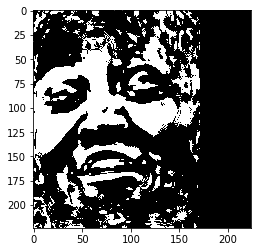

In [84]:
_, rf_thresh = cv2.threshold(rfg_denoised,0,255,cv2.THRESH_OTSU)
plt.figure()
plt.imshow(rf_thresh, cmap='gray')
plt.show()

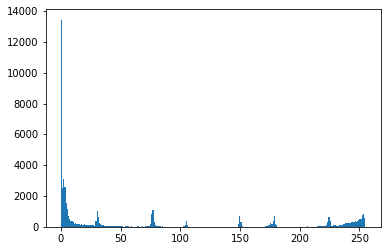

In [85]:
plt.hist(rfg_denoised.ravel(),256,[0,255]) 
plt.show()

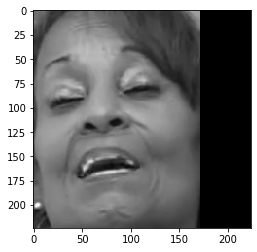

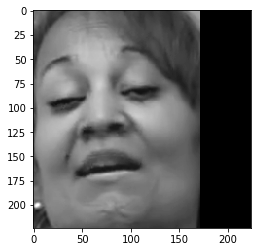

In [65]:
rf0_gray = cv2.cvtColor(rf0, cv2.COLOR_RGB2GRAY)
ff0_gray = cv2.cvtColor(ff0, cv2.COLOR_RGB2GRAY)

plt.figure()
plt.imshow(rf0_gray, cmap='gray')
plt.show()
plt.figure()
plt.imshow(ff0_gray, cmap='gray')
plt.show()

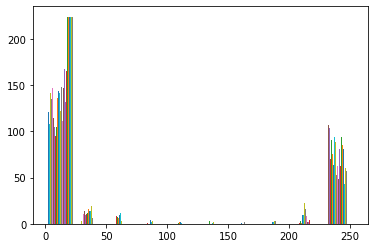

In [95]:
diff = np.zeros(rf0_gray.shape)
for i in range(diff.shape[0]):
    for j in range(diff.shape[1]):
        diff[i][j] = rf0_gray[i][j] - ff0_gray[i][j]

plt.hist(diff)
plt.show()

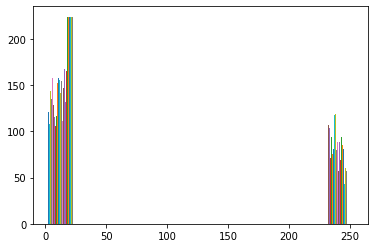

In [96]:
for i in range(diff.shape[0]):
    for j in range(diff.shape[1]):
        if diff[i][j] <= 50:
            diff[i][j] = 0
        else:
            diff[i][j] = 255
plt.hist(diff)
plt.show()


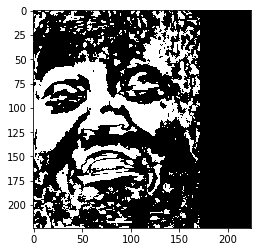

In [97]:
plt.imshow(diff, cmap='gray')

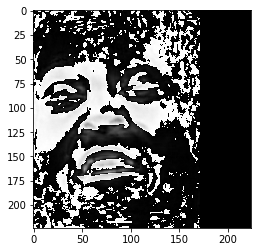

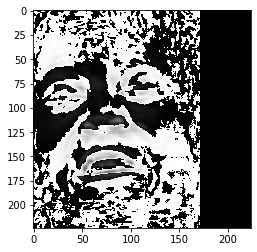

In [66]:
rfg = rf0_gray - ff0_gray
frg = ff0_gray - rf0_gray

plt.figure()
plt.imshow(rfg, cmap='gray')
plt.show()
plt.figure()
plt.imshow(frg, cmap='gray')
plt.show()